In [955]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline

Function to load datasets

In [956]:
def load_datasets(filename, data_columns, target_column):
    df = pd.read_csv(filename)
    df[data_columns + [target_column]] = df[data_columns + [target_column]].apply(pd.to_numeric)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    X, y = df[data_columns], df[target_column]
    return X, y, df

In [957]:
# One-Hot Encoding для категоріальних ознак
def encode_categorical_features(df, cat_columns):
    encoder = OneHotEncoder(sparse_output=False) 
    encoded_features = encoder.fit_transform(df[cat_columns])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_columns))
    df = df.drop(columns=cat_columns).reset_index(drop=True)
    return pd.concat([df, encoded_df], axis=1)


Function to normalize features

In [958]:
def normalize(X):
    mean = X.mean()
    std = X.std()
    X_new = (X - mean)/std
    return X_new, mean,std

Function to prepare features

In [959]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m,1))
    X_new = np.column_stack((ones,X))
    return X_new    

Function for hypothesis calculation

In [960]:
def h(X,theta):
    return np.dot(X,theta)

Cost Function

In [961]:
def cost_function(X,y,theta):
    m = X.shape[0]
    J = (1/(2*m)) * np.sum((h(X,theta)-y)**2)
    return J

Derivative of cost function with respect to theta

In [962]:
def derivative_theta(X,y,theta):
    m = X.shape[0]
    d_theta = (1/m) * np.dot(X.T, (h(X,theta)-y))
    return d_theta

Gradient Descent algorithm

In [963]:
def gradient_descent(X, y, theta, alpha, epsilon, num_iters, print_J=True):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    if print_J:
        print(J)
    J_history.append(J)
    
    for i in range(num_iters):
        theta = theta - alpha * derivative_theta(X, y, theta)
        J = cost_function(X, y, theta)
        J_history.append(J)
        if print_J:
            print(J)
        if abs(J - J_history[-2]) < epsilon:
            break
            
    return theta, J_history

Function to predict

In [964]:
def predict(X, mean, std, theta):
    predictions = h(prepare_X((X - mean) / std), theta)
    return predictions

In [965]:
# Візуалізація категоріальних ознак
def plot_categorical_bars(df, cat_columns):
    for col in cat_columns[:5]:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df[col], order=df[col].value_counts().index)
        plt.title(f'Барчарт для {col}')
        plt.xticks(rotation=45)
        plt.show()

Завантаження датасету

In [966]:
data_columns = ["cont1", "cont2", "cont3","cont4"]
target_column = "loss"
X, y, df_train = load_datasets("G:\\LNU1\\LNU\\ДВ Вступ до машинного навчання\\IT_1\\train.csv", data_columns, target_column)

Матриця кореляції

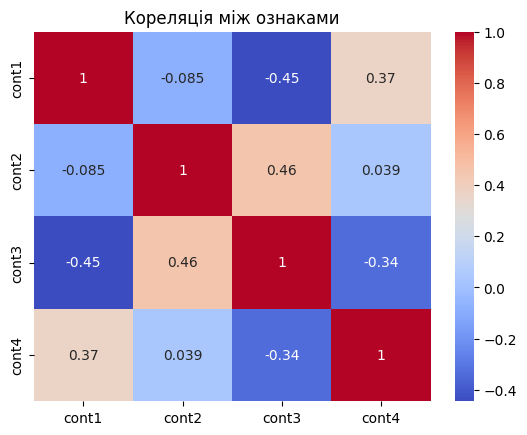

In [967]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Кореляція між ознаками")
plt.show()


In [968]:
# Визначення категоріальних ознак (якщо такі є)
cat_columns = [col for col in df_train.columns if col.startswith("cat")]

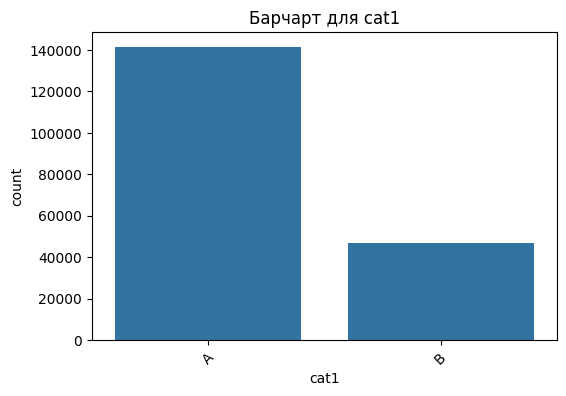

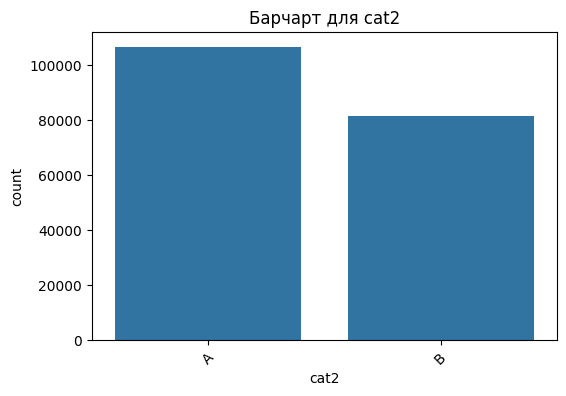

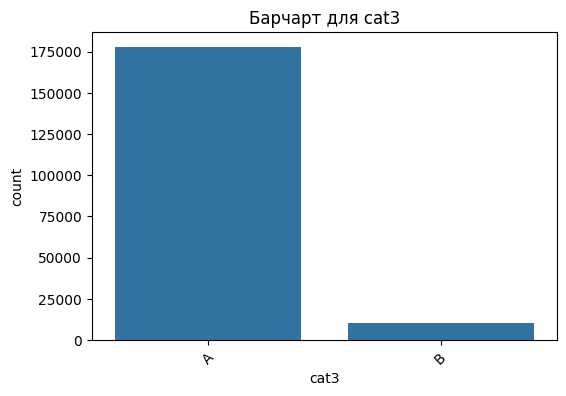

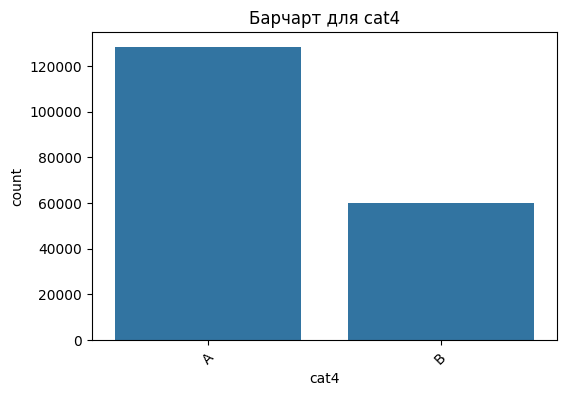

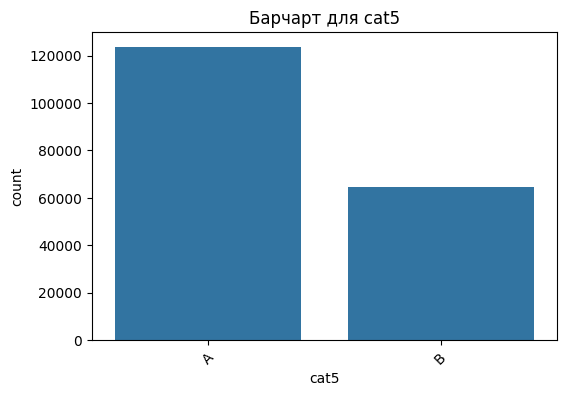

In [969]:
# Візуалізація категоріальних ознак
plot_categorical_bars(df_train, cat_columns)

In [970]:
# Закодування категоріальних змінних
df_train = encode_categorical_features(df_train, cat_columns)

In [971]:
# Розділення вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [972]:
# Нормалізація
mean = X_train.mean()
std = X_train.std()
X_train_normalized, mean, std = normalize(X_train)
X_test_normalized = (X_test - mean) / std

In [973]:
# Підготовка X для тренування
X_train_prep = prepare_X(X_train_normalized)
y_train_prep = y_train.values # Перетворення в array

In [974]:
# Ініціалізація параметрів для градієнтного спуску
theta = np.zeros(X_train_prep.shape[1])

In [975]:
# Тренування
alpha, epsilon, num_iters = 0.01, 1e-6, 2000
new_theta, Js = gradient_descent(X_train_prep, y_train_prep, theta, alpha, epsilon, num_iters, print_J=False)


In [976]:
# Завантажуємо тестовий набір для передбачення
df_test = pd.read_csv("G:\\LNU1\\LNU\\ДВ Вступ до машинного навчання\\IT_1\\test.csv")
X_test = df_test[data_columns]
X_test_normalized = (X_test - mean) / std 

In [977]:
# Прогнозування на тестових даних
y_test = predict(X_test_normalized, mean, std, new_theta)

In [978]:
# Підготовка файлу подання
submission = pd.DataFrame({
    'id': df_test['id'], 
    'loss': y_test
})

In [979]:
submission.to_csv('submission.csv', index=False)
print("Файл подання збережено як 'submission.csv'")

Файл подання збережено як 'submission.csv'


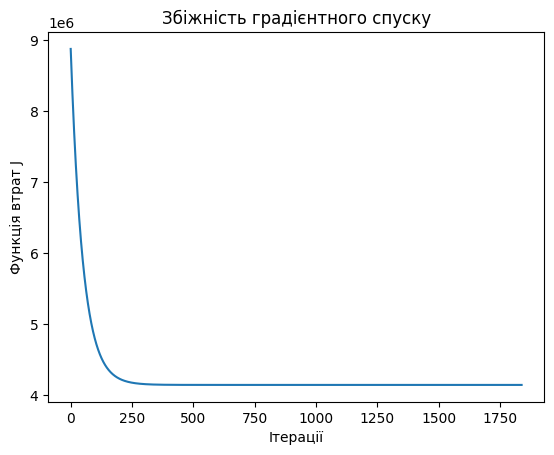

In [980]:
# Візуалізація градієнтного спуску
plt.plot(Js)
plt.xlabel("Ітерації")
plt.ylabel("Функція втрат J")
plt.title("Збіжність градієнтного спуску")
plt.show()

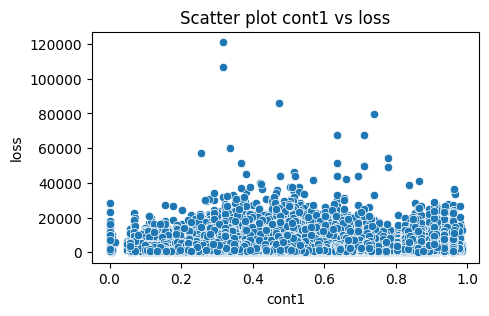

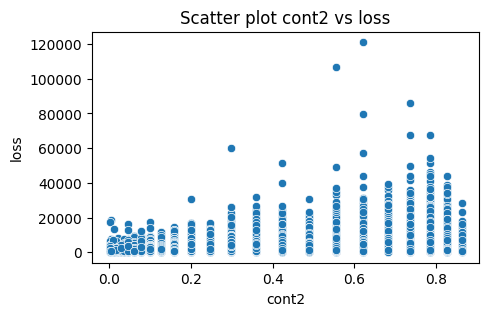

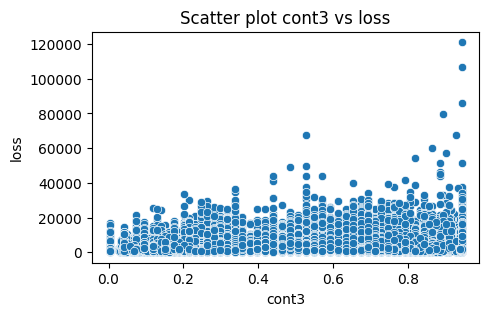

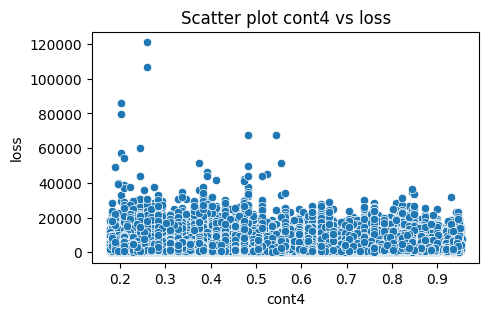

In [981]:
# Scatter plot 
for col in data_columns:
    plt.figure(figsize=(5,3))
    sns.scatterplot(x=X[col], y=y)
    plt.title(f'Scatter plot {col} vs loss')
    plt.show()

In [982]:
# Важливість ознак
feature_importance = np.abs(new_theta[1:])
sorted_idx = np.argsort(feature_importance)[::-1]
print("Feature importance:")
for idx in sorted_idx:
    print(f"{data_columns[idx]}: {feature_importance[idx]}")

Feature importance:
cont2: 343.5778008138626
cont3: 188.0233377223242
cont1: 119.62373410618962
cont4: 100.31687938033791


In [983]:
# Оцінка результатів за допомогою Sklearn Linear Regression
model = LinearRegression()
model.fit(X_train_normalized, y_train)
y_pred_sklearn = model.predict(X_train_normalized)
print("Sklearn RMSE:", np.sqrt(metrics.mean_squared_error(y_train, y_pred_sklearn)))




Sklearn RMSE: 2879.460201119755


In [984]:
# Оцінка результатів
predictions = predict(X_train_normalized, mean, std, new_theta)
print("MAE:", metrics.mean_absolute_error(y_train, predictions))
print("MSE:", metrics.mean_squared_error(y_train, predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_train, predictions)))
print("Hello Yura")

MAE: 2719.6614345221337
MSE: 13332646.770230062
RMSE: 3651.3897039661574
Hello Yura


In [985]:
# Grid Search для Ridge регресії
ridge_model = Ridge()
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(ridge_model, param_grid=params, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train_normalized, y_train)
print("Найкращий параметр:", grid.best_params_)

Найкращий параметр: {'alpha': 10}
